# LOMMIS Flight Data Comparison Analysis
## Comparing TRUTH CSV vs Generated Excel Files

This notebook compares the TRUTH CSV file with the generated Excel file to identify discrepancies in:
- Registration numbers
- Dates (Day, Month, Year)
- Times (accounting for 1-hour offset where TRUTH is ahead)
- Routes
- Movement types

In [44]:
# Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
import os
warnings.filterwarnings('ignore')
from traffic.core import Traffic

print("Libraries imported successfully!")

Libraries imported successfully!


In [45]:
# Configuration Parameters - Change these to analyze different months/years
import os
from datetime import datetime

# Set your desired month and year here
YEAR = 2025
MONTH = 3

# Generate file identifiers
month_str = f"{MONTH:02d}"
year_str = str(YEAR)
file_identifier = f"{month_str}{year_str}"

# Auto-generate file paths
excel_generated_file = f"Excel/ARP_LSZT_{file_identifier}.xlsx"
truth_csv_file = f"Excel/ARP_LSZT_{file_identifier}_TRUTH.csv"
results_csv_file = f"Excel/comparison_results_{file_identifier}.csv"

print("="*60)
print("📋 FILE CONFIGURATION")
print("="*60)
print(f"📅 Analysis Period: {datetime(YEAR, MONTH, 1).strftime('%B %Y')}")
print(f"📂 Generated Excel: {excel_generated_file}")
print(f"📂 Truth CSV: {truth_csv_file}")
print(f"📂 Results Output: {results_csv_file}")

# Check if files exist
if os.path.exists(excel_generated_file):
    print(f"✅ Generated file found")
else:
    print(f"❌ Generated file NOT found: {excel_generated_file}")

if os.path.exists(truth_csv_file):
    print(f"✅ Truth file found")
else:
    print(f"❌ Truth file NOT found: {truth_csv_file}")

print("="*60)

# Function to load traffic data and get unique registrations
def load_traffic_registrations(year, month):
    """Load traffic data and extract unique registrations"""
    traffic_file = f"Statistics/{year}-{month:02d}-flights.parquet"
    
    try:
        if os.path.exists(traffic_file):
            traff_set = Traffic.from_file(traffic_file)
            unique_registrations = set(traff_set.data['callsign'].unique())
            print(f"✅ Loaded traffic data: {len(unique_registrations)} unique aircraft")
            return unique_registrations
        else:
            print(f"⚠️ Traffic file not found: {traffic_file}")
            return set()
    except Exception as e:
        print(f"⚠️ Error loading traffic data: {e}")
        return set()

# Load traffic registrations for this month
traffic_registrations = load_traffic_registrations(YEAR, MONTH)
print(f"📊 Total unique aircraft in ADS-B data: {len(traffic_registrations)}")

📋 FILE CONFIGURATION
📅 Analysis Period: March 2025
📂 Generated Excel: Excel/ARP_LSZT_032025.xlsx
📂 Truth CSV: Excel/ARP_LSZT_032025_TRUTH.csv
📂 Results Output: Excel/comparison_results_032025.csv
✅ Generated file found
✅ Truth file found
✅ Loaded traffic data: 18 unique aircraft
📊 Total unique aircraft in ADS-B data: 18


## 1. Read Generated Excel File

In [46]:
# Read the generated Excel file
print("=== LOADING GENERATED EXCEL FILE ===")
print(f"File: {excel_generated_file}")

try:
    df_generated = pd.read_excel(excel_generated_file, sheet_name='DATA')
    print(f"✅ Successfully loaded generated file")
except FileNotFoundError:
    print(f"❌ ERROR: Generated file not found: {excel_generated_file}")
    print("Please check if the file exists or update YEAR/MONTH parameters")
    raise
except Exception as e:
    print(f"❌ ERROR loading generated file: {e}")
    raise

print(f"Raw shape: {df_generated.shape}")
print(f"Raw columns: {df_generated.columns.tolist()}")
print("\nFirst few rows (raw):")
print(df_generated.head(3))

# The actual data starts from row 1 (row 0 contains headers)
df_generated.columns = df_generated.iloc[0]
df_generated = df_generated.drop(df_generated.index[0]).reset_index(drop=True)

# Convert data types
df_generated['DAY'] = pd.to_numeric(df_generated['DAY'], errors='coerce')
df_generated['MONTH'] = pd.to_numeric(df_generated['MONTH'], errors='coerce')
df_generated['YEAR'] = pd.to_numeric(df_generated['YEAR'], errors='coerce')
df_generated['TIME'] = df_generated['TIME'].astype(str).str.zfill(4)

print(f"\nProcessed shape: {df_generated.shape}")
print(f"Processed columns: {df_generated.columns.tolist()}")
print("\nProcessed data sample:")
print(df_generated[['REGISTRATION', 'DAY', 'MONTH', 'YEAR', 'TIME', 'ARR_DEP', 'ROUTE']].head())

=== LOADING GENERATED EXCEL FILE ===
File: Excel/ARP_LSZT_032025.xlsx
✅ Successfully loaded generated file
Raw shape: (312, 15)
Raw columns: ['Monatliche Bewegungsliste für Flugplätze und Flugfelder ohne Linienverkehr', 'Unnamed: 1', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5', 'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9', 'Unnamed: 10', 'Unnamed: 11', 'Unnamed: 12', 'Unnamed: 13', 'Unnamed: 14']

First few rows (raw):
  Monatliche Bewegungsliste für Flugplätze und Flugfelder ohne Linienverkehr  \
0                                            AIRPORT                           
1                                               LSZT                           
2                                               LSZT                           

  Unnamed: 1 Unnamed: 2 Unnamed: 3 Unnamed: 4 Unnamed: 5 Unnamed: 6  \
0        DAY      MONTH       YEAR       TIME    ARR_DEP     REASON   
1         01          3       2025       0901          D          4   
2         01          

## 2. Read TRUTH CSV File

In [47]:
# Read the TRUTH CSV file
print("=== LOADING TRUTH CSV FILE ===")
print(f"File: {truth_csv_file}")

try:
    df_truth = pd.read_csv(truth_csv_file)
    print(f"✅ Successfully loaded truth file")
except FileNotFoundError:
    print(f"❌ ERROR: Truth file not found: {truth_csv_file}")
    print("Please check if the file exists or update YEAR/MONTH parameters")
    raise
except Exception as e:
    print(f"❌ ERROR loading truth file: {e}")
    raise

print(f"Shape: {df_truth.shape}")
print(f"Columns: {df_truth.columns.tolist()}")
print(f"Total columns found: {len(df_truth.columns)}")
print(f"Column data types:")
for col in df_truth.columns:
    print(f"  {col}: {df_truth[col].dtype}")

print("\nColumn meanings:")
print("ARP: Airport code")
print("TYPMO: Movement type (A=Arrival, D=Departure)")  
print("ACREG: Aircraft registration")
print("DATMO: Date (YYYYMMDD)")
print("TIMMO: Time (HHMM)")
print("DIRDE: Direction/Route")
if 'NUMMO' in df_truth.columns:
    print("NUMMO: Movement number")
else:
    print("⚠️  WARNING: NUMMO column NOT FOUND in truth data!")
    print("Available columns that might be NUMMO:")
    for col in df_truth.columns:
        if 'num' in col.lower() or 'mov' in col.lower() or 'mou' in col.lower():
            print(f"  - {col}")

print("\nSample data:")
if 'NUMMO' in df_truth.columns:
    print(df_truth[['ARP', 'TYPMO', 'ACREG', 'DATMO', 'TIMMO', 'DIRDE', 'NUMMO']].head())
else:
    print("Showing all available columns:")
    print(df_truth.head())
    print("\nFirst row values:")
    for i, col in enumerate(df_truth.columns):
        print(f"  Column {i}: {col} = {df_truth.iloc[0, i]}")

# Process TRUTH data
def adjust_time_for_timezone(time_val):
    """Adjust time by subtracting 1 hour (TRUTH is 1 hour ahead)"""
    if pd.isna(time_val):
        return None
    try:
        time_str = str(int(time_val)).zfill(4)
        hour = int(time_str[:2])
        minute = int(time_str[2:])
        dt = datetime(2025, 1, 1, hour, minute)
        adjusted_dt = dt - timedelta(hours=1)
        return adjusted_dt.strftime("%H%M")
    except:
        return None

# Extract day from DATMO and adjust time
df_truth['DAY'] = df_truth['DATMO'].astype(str).str[-2:].astype(int)
df_truth['MONTH'] = MONTH  # Use configured month
df_truth['YEAR'] = YEAR    # Use configured year
df_truth['TIME_ADJUSTED'] = df_truth['TIMMO'].apply(adjust_time_for_timezone)

print(f"\nProcessed TRUTH data:")
if 'NUMMO' in df_truth.columns:
    print(df_truth[['ACREG', 'DAY', 'MONTH', 'YEAR', 'TIMMO', 'TIME_ADJUSTED', 'DIRDE', 'TYPMO', 'NUMMO']].head())
else:
    print("⚠️  NUMMO column missing - showing available columns:")
    print(df_truth[['ACREG', 'DAY', 'MONTH', 'YEAR', 'TIMMO', 'TIME_ADJUSTED', 'DIRDE', 'TYPMO']].head())
    print(f"\nAll truth columns: {df_truth.columns.tolist()}")

=== LOADING TRUTH CSV FILE ===
File: Excel/ARP_LSZT_032025_TRUTH.csv


✅ Successfully loaded truth file
Shape: (447, 15)
Columns: ['ARP', 'TYPMO', 'ACREG', 'TYPTR', 'NUMMO', 'ORIDE', 'PAX', 'DATMO', 'TIMMO', 'PIMO', 'TYPPI', 'DIRDE', 'CID', 'CDT', 'CDM']
Total columns found: 15
Column data types:
  ARP: object
  TYPMO: object
  ACREG: object
  TYPTR: int64
  NUMMO: int64
  ORIDE: object
  PAX: int64
  DATMO: int64
  TIMMO: int64
  PIMO: int64
  TYPPI: object
  DIRDE: object
  CID: object
  CDT: int64
  CDM: int64

Column meanings:
ARP: Airport code
TYPMO: Movement type (A=Arrival, D=Departure)
ACREG: Aircraft registration
DATMO: Date (YYYYMMDD)
TIMMO: Time (HHMM)
DIRDE: Direction/Route
NUMMO: Movement number

Sample data:
    ARP TYPMO  ACREG     DATMO  TIMMO      DIRDE  NUMMO
0  LSZT     D  HBKFW  20250301   1000  matzingen      1
1  LSZT     V  HBSGW  20250301   1015        NaN      6
2  LSZT     A  HBKFW  20250301   1030      south      1
3  LSZT     D  HBETG  20250301   1035  matzingen      1
4  LSZT     D  HBSGW  20250301   1040  matzingen      1

Pr

## 3. File Structure Comparison

In [48]:
# Perform detailed comparison
print("=== DETAILED COMPARISON ===")
print(f"TRUTH records: {len(df_truth)}")
print(f"Generated records: {len(df_generated)}")

comparison_results = []

# Compare each TRUTH record with generated records
for idx, truth_row in df_truth.iterrows():
    registration = truth_row['ACREG']
    day = truth_row['DAY']
    month = truth_row['MONTH']
    year = truth_row['YEAR']
    time_truth = truth_row['TIME_ADJUSTED']
    route_truth = truth_row['DIRDE']
    type_truth = truth_row['TYPMO']
    # Check if NUMMO exists, if not use a placeholder
    nummo_truth = truth_row.get('NUMMO', 'MISSING_COLUMN') if 'NUMMO' in df_truth.columns else 'MISSING_COLUMN'
    
    # Find matching records in generated data
    matches = df_generated[
        (df_generated['REGISTRATION'] == registration) &
        (df_generated['DAY'] == day) &
        (df_generated['MONTH'] == month) &
        (df_generated['YEAR'] == year)
    ]
    
    print(f"DEBUG: Truth flight {registration} on day {day} found {len(matches)} matches in generated data")
    if len(matches) > 1:
        print(f"  ⚠️  MULTIPLE MATCHES DETECTED for {registration} day {day}:")
        for i, (_, match) in enumerate(matches.iterrows()):
            print(f"    Match {i+1}: Time={match['TIME']}, Route={match['ROUTE']}, Type={match['ARR_DEP']}")
    
    if len(matches) == 0:
        # Check if aircraft has ADS-B data
        if registration in traffic_registrations:
            status = 'DETECTOR MISSED'
        else:
            status = 'NO ADS-B DATA'
        
        comparison_results.append({
            'REGISTRATION': registration,
            'DAY': day,
            'TIME_TRUTH': time_truth,
            'TIME_GENERATED': 'NOT FOUND',
            'ROUTE_TRUTH': route_truth,
            'ROUTE_GENERATED': 'NOT FOUND',
            'TYPE_TRUTH': type_truth,
            'TYPE_GENERATED': 'NOT FOUND',
            'NUMMO_TRUTH': nummo_truth,
            'NUMMO_GENERATED': 'NOT FOUND',
            'STATUS': status
        })
    else:
        # Find the best match instead of creating multiple entries
        best_match = None
        best_score = -1
        
        for _, match_row in matches.iterrows():
            time_generated = match_row['TIME']
            route_generated = match_row['ROUTE']
            type_generated = match_row['ARR_DEP']
            nummo_generated = match_row.get('MOUVEMENT', 'N/A')
            
            # Calculate match score
            score = 0
            if str(time_truth) == str(time_generated):
                score += 4  # Time match is most important
            
            # Enhanced route matching
            def routes_match(truth_route, generated_route):
                truth_str = str(truth_route).lower()
                generated_str = str(generated_route).lower()
                if truth_str == generated_str:
                    return True
                directional_mappings = {
                    's': 'south', 'south': 's',
                    'w': 'matzingen', 'matzingen': 'w',
                    'n': 'north', 'north': 'n'
                }
                for direction, full_name in directional_mappings.items():
                    if (direction in truth_str and full_name in generated_str) or \
                       (full_name in truth_str and direction in generated_str):
                        return True
                return False
            
            if routes_match(route_truth, route_generated):
                score += 2
            if type_truth == type_generated:
                score += 2
            if str(nummo_truth) == str(nummo_generated):
                score += 1
                
            if score > best_score:
                best_score = score
                best_match = match_row
        
        # Process the best match
        if best_match is not None:
            time_generated = best_match['TIME']
            route_generated = best_match['ROUTE']
            type_generated = best_match['ARR_DEP']
            nummo_generated = best_match.get('MOUVEMENT', 'N/A')
            
            # Compare fields for final status
            time_match = (str(time_truth) == str(time_generated))
            route_match = routes_match(route_truth, route_generated)
            type_match = (type_truth == type_generated)
            nummo_match = (str(nummo_truth) == str(nummo_generated))
            
            issues = []
            if not time_match:
                issues.append('TIME')
            if not route_match:
                issues.append('ROUTE')
            if not type_match:
                issues.append('TYPE')
            if not nummo_match:
                issues.append('NUMMO')
            
            status = 'MATCH' if not issues else ' & '.join(issues) + ' MISMATCH'
            
            comparison_results.append({
                'REGISTRATION': registration,
                'DAY': day,
                'TIME_TRUTH': time_truth,
                'TIME_GENERATED': time_generated,
                'ROUTE_TRUTH': route_truth,
                'ROUTE_GENERATED': route_generated,
                'TYPE_TRUTH': type_truth,
                'TYPE_GENERATED': type_generated,
                'NUMMO_TRUTH': nummo_truth,
                'NUMMO_GENERATED': nummo_generated,
                'STATUS': status
            })

# Check for extra records in generated data (that don't exist in truth)
processed_generated_flights = set()

for idx, gen_row in df_generated.iterrows():
    registration = gen_row['REGISTRATION']
    day = gen_row['DAY']
    month = gen_row['MONTH']
    year = gen_row['YEAR']
    time_gen = gen_row['TIME']
    
    # Create unique identifier for this generated flight
    flight_id = f"{registration}_{day}_{time_gen}"
    
    # Skip if we already processed this exact flight
    if flight_id in processed_generated_flights:
        print(f"DEBUG: Skipping duplicate generated flight: {flight_id}")
        continue
    
    processed_generated_flights.add(flight_id)
    
    # Check if this generated flight exists in truth data
    matches = df_truth[
        (df_truth['ACREG'] == registration) &
        (df_truth['DAY'] == day) &
        (df_truth['MONTH'] == month) &
        (df_truth['YEAR'] == year)
    ]
    
    if len(matches) == 0:
        print(f"DEBUG: Extra generated flight found: {registration} day {day} time {time_gen}")
        comparison_results.append({
            'REGISTRATION': registration,
            'DAY': day,
            'TIME_TRUTH': 'NOT FOUND',
            'TIME_GENERATED': gen_row['TIME'],
            'ROUTE_TRUTH': 'NOT FOUND',
            'ROUTE_GENERATED': gen_row['ROUTE'],
            'TYPE_TRUTH': 'NOT FOUND',
            'TYPE_GENERATED': gen_row['ARR_DEP'],
            'NUMMO_TRUTH': 'NOT FOUND',
            'NUMMO_GENERATED': gen_row.get('MOUVEMENT', 'N/A'),
            'STATUS': 'EXTRA IN GENERATED'
        })

results_df = pd.DataFrame(comparison_results)
print(f"\nTotal comparison records: {len(results_df)}")
print(f"Unique flights in results: {len(results_df.drop_duplicates(['REGISTRATION', 'DAY', 'TIME_TRUTH', 'TIME_GENERATED']))}")
print("\nStatus breakdown:")
status_counts = results_df['STATUS'].value_counts()
print(status_counts)

# Check for any remaining duplicates
duplicates = results_df[results_df.duplicated(['REGISTRATION', 'DAY'], keep=False)]
if len(duplicates) > 0:
    print(f"\n⚠️  WARNING: Found {len(duplicates)} potential duplicate entries:")
    print(duplicates[['REGISTRATION', 'DAY', 'TIME_TRUTH', 'TIME_GENERATED', 'STATUS']].to_string(index=False))
else:
    print("\n✅ No duplicate entries found in results!")

=== DETAILED COMPARISON ===
TRUTH records: 447
Generated records: 311
DEBUG: Truth flight HBKFW on day 1 found 2 matches in generated data
  ⚠️  MULTIPLE MATCHES DETECTED for HBKFW day 1:
    Match 1: Time=0908, Route=SW, Type=D
    Match 2: Time=0932, Route=SO, Type=A
DEBUG: Truth flight HBSGW on day 1 found 4 matches in generated data
  ⚠️  MULTIPLE MATCHES DETECTED for HBSGW day 1:
    Match 1: Time=0901, Route=SO, Type=D
    Match 2: Time=0901, Route=nan, Type=V
    Match 3: Time=0915, Route=SW, Type=A
    Match 4: Time=0954, Route=SW, Type=D
DEBUG: Truth flight HBKFW on day 1 found 2 matches in generated data
  ⚠️  MULTIPLE MATCHES DETECTED for HBKFW day 1:
    Match 1: Time=0908, Route=SW, Type=D
    Match 2: Time=0932, Route=SO, Type=A
DEBUG: Truth flight HBETG on day 1 found 1 matches in generated data
DEBUG: Truth flight HBSGW on day 1 found 4 matches in generated data
  ⚠️  MULTIPLE MATCHES DETECTED for HBSGW day 1:
    Match 1: Time=0901, Route=SO, Type=D
    Match 2: Time=0

In [49]:
# Calculate missing records percentage
no_adsb_records = results_df[results_df['STATUS'] == 'NO ADS-B DATA']
detector_missed_records = results_df[results_df['STATUS'] == 'DETECTOR MISSED']
total_truth_records = len(df_truth)

# For backwards compatibility, also check for old 'MISSING IN GENERATED' status
old_missing_records = results_df[results_df['STATUS'] == 'MISSING IN GENERATED']

# Count total missing flights
missing_count = len(no_adsb_records) + len(detector_missed_records) + len(old_missing_records)
missing_percentage = (missing_count / total_truth_records) * 100

# Create missing_records variable for backwards compatibility with other cells
missing_records = pd.concat([no_adsb_records, detector_missed_records, old_missing_records]) if missing_count > 0 else pd.DataFrame()

print("="*60)
print("MISSING RECORDS ANALYSIS")
print("="*60)
print(f"📊 Total TRUTH records: {total_truth_records}")
print(f"❌ Total Missing: {missing_count}")
print(f"   ├─ NO ADS-B DATA: {len(no_adsb_records)}")
print(f"   └─ DETECTOR MISSED: {len(detector_missed_records)}")
print(f"📈 Missing percentage: {missing_percentage:.1f}%")
print()

if missing_count > 0:
    print("Missing flights details (sample of 20):")
    all_missing = pd.concat([no_adsb_records, detector_missed_records, old_missing_records])
    for idx, row in all_missing.head(20).iterrows():
        print(f"  • {row['REGISTRATION']} on day {row['DAY']} at {row['TIME_TRUTH']} ({row['TYPE_TRUTH']}) - Route: {row['ROUTE_TRUTH']} - {row['STATUS']}")
else:
    print("✅ No missing flights!")

print("="*60)

MISSING RECORDS ANALYSIS
📊 Total TRUTH records: 447
❌ Total Missing: 149
   ├─ NO ADS-B DATA: 143
   └─ DETECTOR MISSED: 6
📈 Missing percentage: 33.3%

Missing flights details (sample of 20):
  • HBTDA on day 2 at 1345 (A) - Route: south - NO ADS-B DATA
  • HBTDA on day 2 at 1415 (D) - Route: south - NO ADS-B DATA
  • HBONA on day 2 at 1505 (A) - Route: south - NO ADS-B DATA
  • HBONA on day 2 at 1545 (D) - Route: south - NO ADS-B DATA
  • HBEGO on day 3 at 1010 (D) - Route: south - NO ADS-B DATA
  • HBEGO on day 3 at 1515 (A) - Route: south - NO ADS-B DATA
  • HBEGO on day 4 at 1020 (D) - Route: south - NO ADS-B DATA
  • HBPHP on day 4 at 1300 (D) - Route: south - NO ADS-B DATA
  • HBEGO on day 4 at 1405 (A) - Route: south - NO ADS-B DATA
  • HBEGO on day 5 at 1015 (D) - Route: south - NO ADS-B DATA
  • HBPHP on day 5 at 1040 (A) - Route: north - NO ADS-B DATA
  • HBEGO on day 5 at 1510 (A) - Route: south - NO ADS-B DATA
  • HBCIX on day 5 at 1601 (A) - Route: south - NO ADS-B DATA
  

## 3.5. Missing Aircraft Analysis

MISSING AIRCRAFT ANALYSIS
📊 MOST FREQUENTLY MISSING AIRCRAFT:

1. 🛩️  HBEGO
   Missing flights: 34
   Flight times: 1010, 1515, 1020, 1405, 1015, 1510, 1025, 1430, 1020, 1510, 1310, 1550, 1045, 1405, 1325, 1500, 1030, 1520, 1010, 1530, 1030, 1455, 1330, 1515, 1315, 1455, 0915, 1035, 1245, 1505, 1015, 1420, 1045, 1520
   Movement types: D, A
   Routes: north, matzingen, south
   📅 Detailed missing flights:
      • Day 3: 1010 (D) via south
      • Day 3: 1515 (A) via south
      • Day 4: 1020 (D) via south
      • Day 4: 1405 (A) via south
      • Day 5: 1015 (D) via south
      • Day 5: 1510 (A) via south
      • Day 6: 1025 (D) via south
      • Day 6: 1430 (A) via south
      • Day 7: 1020 (D) via south
      • Day 7: 1510 (A) via south
      • Day 10: 1310 (D) via matzingen
      • Day 10: 1550 (A) via south
      • Day 11: 1045 (D) via south
      • Day 11: 1405 (A) via south
      • Day 13: 1325 (D) via south
      • Day 13: 1500 (A) via north
      • Day 18: 1030 (D) via south
  

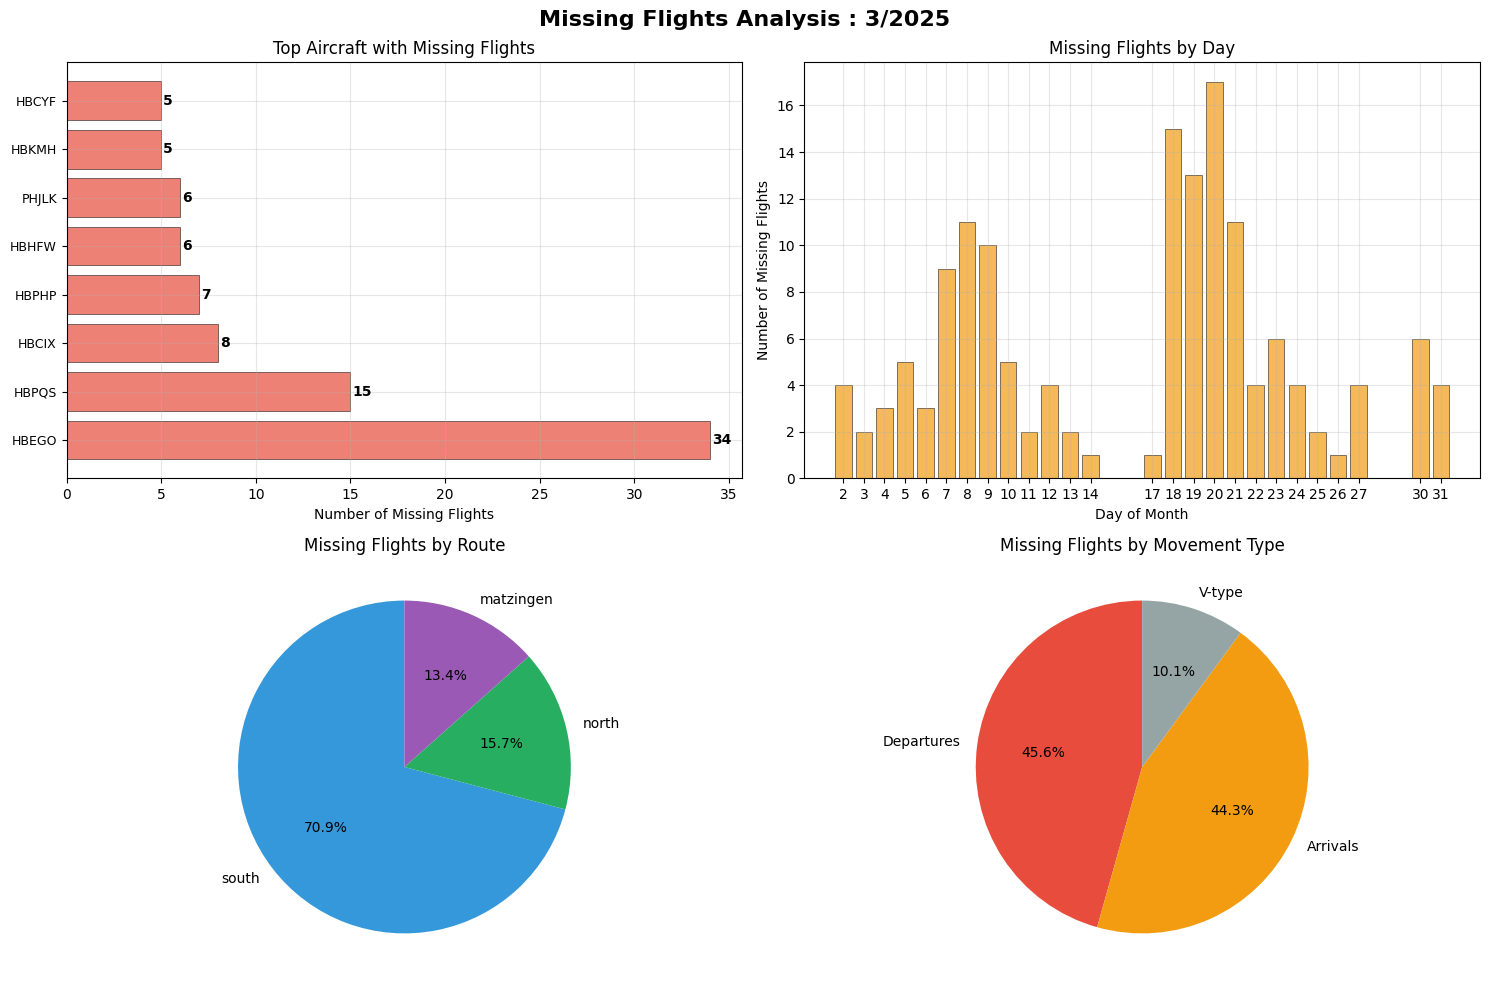


📋 MISSING FLIGHTS INSIGHTS:
• Most affected aircraft: HBEGO (34 missing flights)
• Most problematic day: Day 20
• Most affected route: south
• Total unique aircraft missing flights: 35
• Average missing flights per affected aircraft: 4.3


In [50]:
# Missing Aircraft Analysis
print("="*80)
print("MISSING AIRCRAFT ANALYSIS")
print("="*80)

if missing_count > 0:
    # Analyze missing flights by aircraft registration
    missing_by_aircraft = missing_records.groupby('REGISTRATION').agg({
        'DAY': 'count',
        'TIME_TRUTH': lambda x: list(x),
        'TYPE_TRUTH': lambda x: list(x),
        'ROUTE_TRUTH': lambda x: list(x)
    }).round(1)
    
    missing_by_aircraft.columns = ['Missing_Count', 'Times', 'Types', 'Routes']
    missing_by_aircraft = missing_by_aircraft.sort_values('Missing_Count', ascending=False)
    
    print(f"📊 MOST FREQUENTLY MISSING AIRCRAFT:")
    print("=" * 50)
    
    for idx, (aircraft, data) in enumerate(missing_by_aircraft.head(10).iterrows()):
        print(f"\n{idx+1}. 🛩️  {aircraft}")
        print(f"   Missing flights: {data['Missing_Count']}")
        print(f"   Flight times: {', '.join(data['Times'])}")
        print(f"   Movement types: {', '.join(set(data['Types']))}")
        print(f"   Routes: {', '.join(set(str(r) for r in data['Routes']))}")
        
        # Show individual missing flights for top 3 aircraft
        if idx < 3:
            aircraft_missing = missing_records[missing_records['REGISTRATION'] == aircraft]
            print(f"   📅 Detailed missing flights:")
            for _, flight in aircraft_missing.iterrows():
                print(f"      • Day {int(flight['DAY'])}: {flight['TIME_TRUTH']} ({flight['TYPE_TRUTH']}) via {flight['ROUTE_TRUTH']}")
    
    # Analyze missing flights by day
    print(f"\n📅 MISSING FLIGHTS BY DAY:")
    print("=" * 30)
    missing_by_day = missing_records.groupby('DAY').agg({
        'REGISTRATION': ['count', lambda x: list(x)]
    })
    missing_by_day.columns = ['Count', 'Aircraft_List']
    missing_by_day = missing_by_day.sort_values('Count', ascending=False)
    
    for day, data in missing_by_day.head(10).iterrows():
        aircraft_list = missing_records[missing_records['DAY'] == day]['REGISTRATION'].tolist()
        unique_aircraft = list(set(aircraft_list))
        print(f"   Day {int(day)}: {data['Count']} missing flights")
        print(f"      Aircraft: {', '.join(unique_aircraft)}")
    
    # Analyze missing flights by route
    print(f"\n🛣️  MISSING FLIGHTS BY ROUTE:")
    print("=" * 32)
    missing_by_route = missing_records.groupby('ROUTE_TRUTH').agg({
        'REGISTRATION': ['count', lambda x: len(set(x))]
    })
    missing_by_route.columns = ['Total_Missing', 'Unique_Aircraft']
    missing_by_route = missing_by_route.sort_values('Total_Missing', ascending=False)
    
    for route, data in missing_by_route.iterrows():
        route_name = str(route) if str(route) != 'nan' else 'Unknown/Missing'
        print(f"   {route_name}: {data['Total_Missing']} missing flights from {data['Unique_Aircraft']} aircraft")
    
    # Analyze missing flights by movement type
    print(f"\n✈️  MISSING FLIGHTS BY MOVEMENT TYPE:")
    print("=" * 38)
    missing_by_type = missing_records.groupby('TYPE_TRUTH').agg({
        'REGISTRATION': ['count', lambda x: len(set(x))]
    })
    missing_by_type.columns = ['Total_Missing', 'Unique_Aircraft']
    missing_by_type = missing_by_type.sort_values('Total_Missing', ascending=False)
    
    for mov_type, data in missing_by_type.iterrows():
        type_name = {'A': 'Arrivals', 'D': 'Departures', 'V': 'V-type'}.get(mov_type, mov_type)
        print(f"   {type_name}: {data['Total_Missing']} missing flights from {data['Unique_Aircraft']} aircraft")
    
    # Analyze missing flights by time patterns
    print(f"\n🕐 MISSING FLIGHTS BY TIME PATTERNS:")
    print("=" * 40)
    
    # Convert times to hours for analysis
    def extract_hour_from_time(time_str):
        try:
            return int(str(time_str)[:2]) if pd.notna(time_str) else None
        except:
            return None
    
    missing_records['Hour'] = missing_records['TIME_TRUTH'].apply(extract_hour_from_time)
    missing_by_hour = missing_records.groupby('Hour')['REGISTRATION'].count().sort_values(ascending=False)
    
    print("   Missing flights by hour of day:")
    for hour, count in missing_by_hour.head(8).items():
        if hour is not None:
            print(f"   {hour:02d}:XX hours: {count} missing flights")
    
    # Identify aircraft with systematic missing patterns
    print(f"\n🔍 SYSTEMATIC MISSING PATTERNS:")
    print("=" * 38)
    
    # Aircraft missing multiple times
    frequent_missing = missing_by_aircraft[missing_by_aircraft['Missing_Count'] >= 2]
    if len(frequent_missing) > 0:
        print(f"   Aircraft with multiple missing flights:")
        for aircraft, data in frequent_missing.iterrows():
            print(f"   • {aircraft}: {data['Missing_Count']} missing flights")
            
            # Check for specific patterns
            routes = set(str(r) for r in data['Routes'])
            types = set(data['Types'])
            times = data['Times']
            
            if len(routes) == 1 and list(routes)[0] != 'nan':
                print(f"     → Always missing on route: {list(routes)[0]}")
            if len(types) == 1:
                print(f"     → Always missing for type: {list(types)[0]}")
            if len(set(times)) < len(times):
                print(f"     → Multiple flights at same times detected")
    else:
        print("   No aircraft with multiple missing flights detected.")
    
    # Create missing flights visualization
    if len(missing_by_aircraft) > 0:
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle(f'Missing Flights Analysis : {MONTH}/{YEAR}', fontsize=16, fontweight='bold')
        
        # 1. Top missing aircraft
        top_missing = missing_by_aircraft.head(8)
        axes[0,0].barh(range(len(top_missing)), top_missing['Missing_Count'], 
                      color='#E74C3C', alpha=0.7, edgecolor='black', linewidth=0.5)
        axes[0,0].set_yticks(range(len(top_missing)))
        axes[0,0].set_yticklabels(top_missing.index, fontsize=9)
        axes[0,0].set_xlabel('Number of Missing Flights')
        axes[0,0].set_title('Top Aircraft with Missing Flights')
        axes[0,0].grid(True, alpha=0.3, axis='x')
        
        # Add value labels
        for i, v in enumerate(top_missing['Missing_Count']):
            axes[0,0].text(v + 0.1, i, str(v), va='center', fontweight='bold')
        
        # 2. Missing flights by day
        missing_day_counts = missing_records['DAY'].value_counts().sort_index()
        axes[0,1].bar(missing_day_counts.index, missing_day_counts.values, 
                     color='#F39C12', alpha=0.7, edgecolor='black', linewidth=0.5)
        axes[0,1].set_xlabel('Day of Month')
        axes[0,1].set_ylabel('Number of Missing Flights')
        axes[0,1].set_title('Missing Flights by Day')
        axes[0,1].grid(True, alpha=0.3, axis='y')
        
        # Force integer x-axis labels
        axes[0,1].set_xticks(missing_day_counts.index)
        axes[0,1].set_xticklabels([int(day) for day in missing_day_counts.index])
        
        # 3. Missing flights by route
        route_counts = missing_records['ROUTE_TRUTH'].value_counts()
        # Clean up route names for display
        route_labels = [str(r) if str(r) != 'nan' else 'Unknown' for r in route_counts.index]
        axes[1,0].pie(route_counts.values, labels=route_labels, autopct='%1.1f%%', 
                     startangle=90, colors=['#3498DB', '#27AE60', '#9B59B6', '#1ABC9C'])
        axes[1,0].set_title('Missing Flights by Route')
        
        # 4. Missing flights by movement type
        type_counts = missing_records['TYPE_TRUTH'].value_counts()
        type_labels = [{'A': 'Arrivals', 'D': 'Departures', 'V': 'V-type'}.get(t, t) for t in type_counts.index]
        axes[1,1].pie(type_counts.values, labels=type_labels, autopct='%1.1f%%', 
                     startangle=90, colors=['#E74C3C', '#F39C12', '#95A5A6'])
        axes[1,1].set_title('Missing Flights by Movement Type')
        
        plt.tight_layout()
        plt.show()
    
    # Summary insights
    print(f"\n📋 MISSING FLIGHTS INSIGHTS:")
    print("=" * 35)
    most_missing_aircraft = missing_by_aircraft.index[0]
    most_missing_count = missing_by_aircraft.iloc[0]['Missing_Count']
    most_problematic_day = missing_records['DAY'].value_counts().index[0]
    most_problematic_route = missing_records['ROUTE_TRUTH'].value_counts().index[0]
    
    print(f"• Most affected aircraft: {most_missing_aircraft} ({most_missing_count} missing flights)")
    print(f"• Most problematic day: Day {int(most_problematic_day)}")
    print(f"• Most affected route: {most_problematic_route}")
    print(f"• Total unique aircraft missing flights: {len(missing_by_aircraft)}")
    print(f"• Average missing flights per affected aircraft: {missing_by_aircraft['Missing_Count'].mean():.1f}")
    
    # Save detailed missing analysis
    # missing_analysis_file = results_csv_file.replace('.csv', '_missing_analysis.csv')
    # missing_records_detailed = missing_records.copy()
    # missing_records_detailed['Hour'] = missing_records_detailed['TIME_TRUTH'].apply(extract_hour_from_time)
    # missing_records_detailed.to_csv(missing_analysis_file, index=False)
    # print(f"\n✅ Detailed missing flights analysis saved to: {missing_analysis_file}")

else:
    print("🎉 NO MISSING FLIGHTS FOUND! All truth flights are present in generated data.")

print("="*80)

## 4. Detailed Discrepancy Analysis

In [51]:
# Show detailed discrepancies
discrepancies = results_df[results_df['STATUS'] != 'MATCH']

print("="*80)
print("DISCREPANCY DETAILS")
print("="*80)

if len(discrepancies) > 0:
    print(f"\n{len(discrepancies)} DISCREPANCIES FOUND:\n")
    
    # Group by status type
    for status in discrepancies['STATUS'].unique():
        status_group = discrepancies[discrepancies['STATUS'] == status]
        print(f"\n--- {status} ({len(status_group)} records) ---")
        
        for idx, row in status_group.iterrows():
            print(f"Registration: {row['REGISTRATION']}, Day: {row['DAY']}")
            print(f"  Time - Truth: {row['TIME_TRUTH']}, Generated: {row['TIME_GENERATED']}")
            print(f"  Route - Truth: {row['ROUTE_TRUTH']}, Generated: {row['ROUTE_GENERATED']}")
            print(f"  Type - Truth: {row['TYPE_TRUTH']}, Generated: {row['TYPE_GENERATED']}")
            print(f"  NUMMO - Truth: {row['NUMMO_TRUTH']}, Generated: {row['NUMMO_GENERATED']}")
            print()
    
    # Show summary table
    print("\nSUMMARY TABLE:")
    print(discrepancies[['REGISTRATION', 'DAY', 'TIME_TRUTH', 'TIME_GENERATED', 
                        'ROUTE_TRUTH', 'ROUTE_GENERATED', 'NUMMO_TRUTH', 'NUMMO_GENERATED', 'STATUS']].to_string(index=False))
else:
    print("🎉 NO DISCREPANCIES FOUND! All records match perfectly.")

# Save results
results_df.to_csv(results_csv_file, index=False)
print(f"\n✅ Detailed results saved to: {results_csv_file}")

DISCREPANCY DETAILS

439 DISCREPANCIES FOUND:


--- TIME MISMATCH (248 records) ---
Registration: HBKFW, Day: 1
  Time - Truth: 0900, Generated: 0908
  Route - Truth: matzingen, Generated: SW
  Type - Truth: D, Generated: D
  NUMMO - Truth: 1, Generated: 1

Registration: HBSGW, Day: 1
  Time - Truth: 0915, Generated: 0901
  Route - Truth: nan, Generated: nan
  Type - Truth: V, Generated: V
  NUMMO - Truth: 6, Generated: 6

Registration: HBKFW, Day: 1
  Time - Truth: 0930, Generated: 0932
  Route - Truth: south, Generated: SO
  Type - Truth: A, Generated: A
  NUMMO - Truth: 1, Generated: 1

Registration: HBETG, Day: 1
  Time - Truth: 0935, Generated: 0957
  Route - Truth: matzingen, Generated: SW
  Type - Truth: D, Generated: D
  NUMMO - Truth: 1, Generated: 1

Registration: HBSGW, Day: 1
  Time - Truth: 0940, Generated: 0954
  Route - Truth: matzingen, Generated: SW
  Type - Truth: D, Generated: D
  NUMMO - Truth: 1, Generated: 1

Registration: HBKLA, Day: 1
  Time - Truth: 1000, Gener

## 4.5. Time Difference Analysis

TIME DIFFERENCE ANALYSIS
Analyzing time differences for 298 flights with valid times...

TIME DIFFERENCE STATISTICS:
Total flights analyzed: 298
Mean time difference: -42.6 minutes
Median time difference: -2.0 minutes
Standard deviation: 106.3 minutes
Min difference: -442.0 minutes
Max difference: 294.0 minutes

TIME DIFFERENCE CATEGORIES:
Exact matches (0 min): 14 (4.7%)
Small differences (≤5 min): 92 (30.9%)
Medium differences (5-30 min): 106 (35.6%)
Large differences (>30 min): 100 (33.6%)

FLIGHTS WITH LARGE TIME DIFFERENCES (>30 minutes):
  HBKLD on day 8: Truth=1530, Generated=0808 (Diff: -442 min, Route: nan, Type: V)
  HBKLD on day 8: Truth=1530, Generated=0820 (Diff: -430 min, Route: south, Type: A)
  HBSGT on day 19: Truth=1600, Generated=0919 (Diff: -401 min, Route: south, Type: D)
  HBSGW on day 24: Truth=1500, Generated=0833 (Diff: -387 min, Route: matzingen, Type: D)
  HBETG on day 8: Truth=1623, Generated=1028 (Diff: -355 min, Route: north, Type: A)
  HBSGT on day 19: Tr

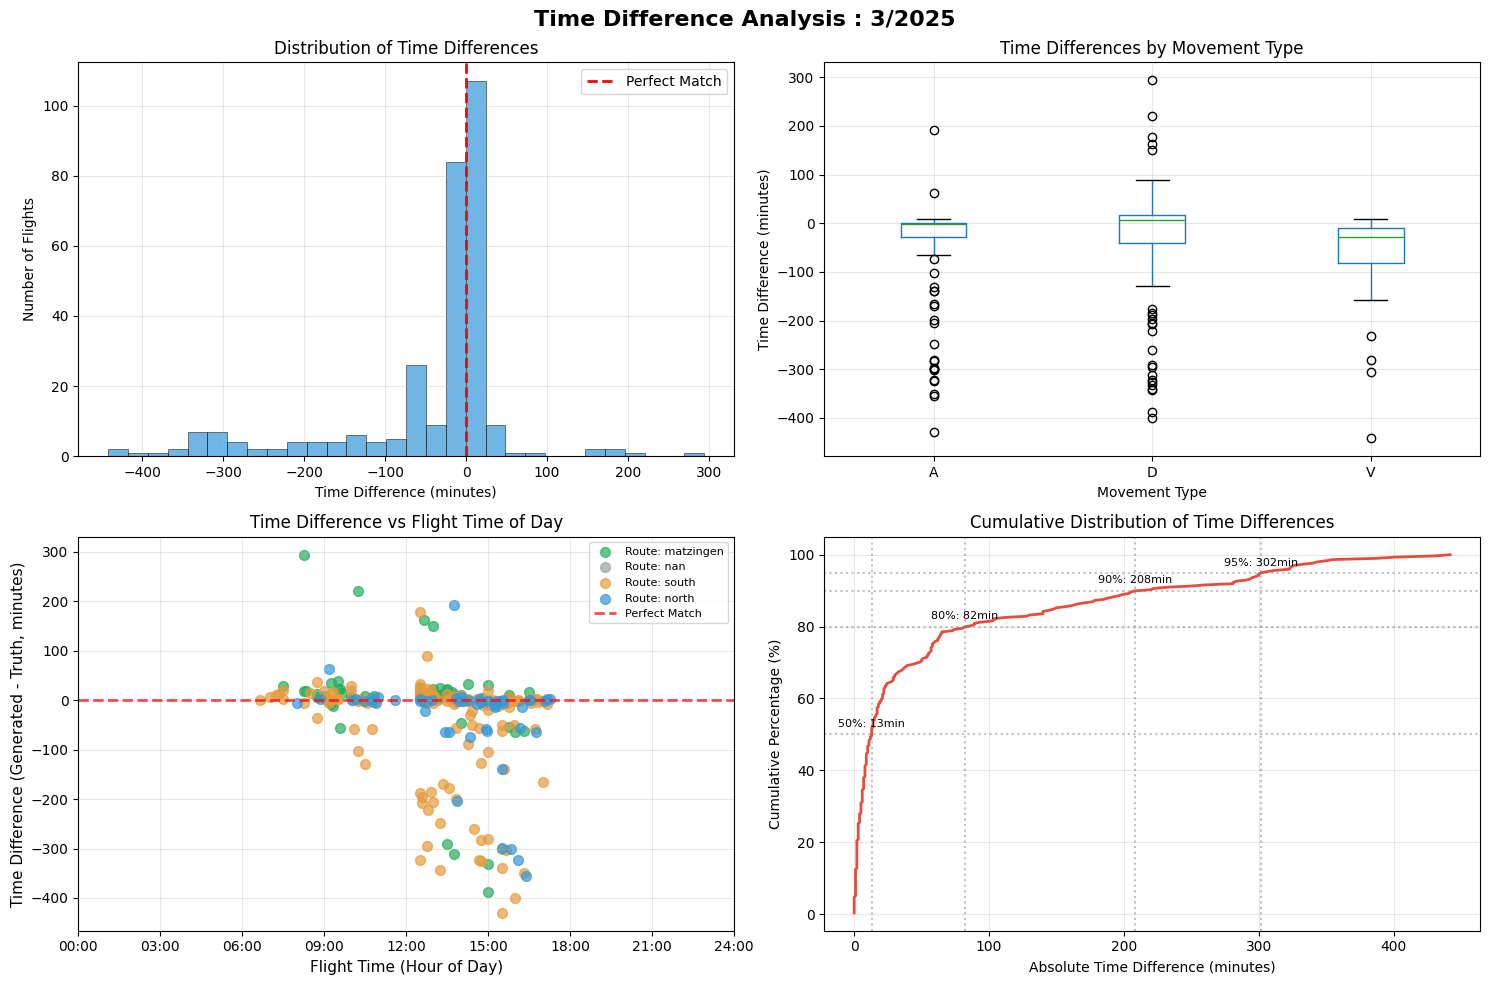


✅ Time analysis results saved to: Excel/comparison_results_032025_time_analysis.csv


In [52]:
# Time Difference Analysis
print("="*80)
print("TIME DIFFERENCE ANALYSIS")
print("="*80)

# Function to convert time string to minutes since midnight
def time_to_minutes(time_str):
    """Convert time string (HHMM) to minutes since midnight"""
    if pd.isna(time_str) or str(time_str) == 'NOT FOUND':
        return None
    try:
        time_str = str(time_str).zfill(4)
        hours = int(time_str[:2])
        minutes = int(time_str[2:])
        return hours * 60 + minutes
    except:
        return None

# Function to calculate time difference in minutes
def calculate_time_diff(truth_time, generated_time):
    """Calculate time difference in minutes (generated - truth)"""
    truth_min = time_to_minutes(truth_time)
    gen_min = time_to_minutes(generated_time)
    
    if truth_min is None or gen_min is None:
        return None
    
    diff = gen_min - truth_min
    
    # Handle day boundary crossings (e.g., 23:59 to 00:05)
    if diff > 12 * 60:  # More than 12 hours positive
        diff -= 24 * 60
    elif diff < -12 * 60:  # More than 12 hours negative
        diff += 24 * 60
    
    return diff

# Calculate time differences for all matching records
time_analysis_data = []
matches_with_times = results_df[
    (results_df['TIME_TRUTH'] != 'NOT FOUND') & 
    (results_df['TIME_GENERATED'] != 'NOT FOUND')
].copy()

print(f"Analyzing time differences for {len(matches_with_times)} flights with valid times...")

for idx, row in matches_with_times.iterrows():
    truth_time = row['TIME_TRUTH']
    generated_time = row['TIME_GENERATED']
    time_diff = calculate_time_diff(truth_time, generated_time)
    
    if time_diff is not None:
        time_analysis_data.append({
            'REGISTRATION': row['REGISTRATION'],
            'DAY': row['DAY'],
            'TIME_TRUTH': truth_time,
            'TIME_GENERATED': generated_time,
            'TIME_DIFF_MINUTES': time_diff,
            'TIME_DIFF_HOURS': round(time_diff / 60, 2),
            'STATUS': row['STATUS'],
            'ROUTE_TRUTH': row['ROUTE_TRUTH'],
            'TYPE_TRUTH': row['TYPE_TRUTH']
        })

time_analysis_df = pd.DataFrame(time_analysis_data)

if len(time_analysis_df) > 0:
    # Basic statistics
    print(f"\nTIME DIFFERENCE STATISTICS:")
    print(f"Total flights analyzed: {len(time_analysis_df)}")
    print(f"Mean time difference: {time_analysis_df['TIME_DIFF_MINUTES'].mean():.1f} minutes")
    print(f"Median time difference: {time_analysis_df['TIME_DIFF_MINUTES'].median():.1f} minutes")
    print(f"Standard deviation: {time_analysis_df['TIME_DIFF_MINUTES'].std():.1f} minutes")
    print(f"Min difference: {time_analysis_df['TIME_DIFF_MINUTES'].min():.1f} minutes")
    print(f"Max difference: {time_analysis_df['TIME_DIFF_MINUTES'].max():.1f} minutes")
    
    # Categorize time differences
    exact_matches = time_analysis_df[time_analysis_df['TIME_DIFF_MINUTES'] == 0]
    small_diff = time_analysis_df[abs(time_analysis_df['TIME_DIFF_MINUTES']) <= 5]
    medium_diff = time_analysis_df[(abs(time_analysis_df['TIME_DIFF_MINUTES']) > 5) & 
                                   (abs(time_analysis_df['TIME_DIFF_MINUTES']) <= 30)]
    large_diff = time_analysis_df[abs(time_analysis_df['TIME_DIFF_MINUTES']) > 30]
    
    print(f"\nTIME DIFFERENCE CATEGORIES:")
    print(f"Exact matches (0 min): {len(exact_matches)} ({len(exact_matches)/len(time_analysis_df)*100:.1f}%)")
    print(f"Small differences (≤5 min): {len(small_diff)} ({len(small_diff)/len(time_analysis_df)*100:.1f}%)")
    print(f"Medium differences (5-30 min): {len(medium_diff)} ({len(medium_diff)/len(time_analysis_df)*100:.1f}%)")
    print(f"Large differences (>30 min): {len(large_diff)} ({len(large_diff)/len(time_analysis_df)*100:.1f}%)")
    
    # Show flights with largest time differences
    if len(large_diff) > 0:
        print(f"\nFLIGHTS WITH LARGE TIME DIFFERENCES (>30 minutes):")
        large_diff_sorted = large_diff.sort_values('TIME_DIFF_MINUTES', key=abs, ascending=False)
        for idx, row in large_diff_sorted.head(10).iterrows():
            sign = "+" if row['TIME_DIFF_MINUTES'] > 0 else ""
            print(f"  {row['REGISTRATION']} on day {row['DAY']}: Truth={row['TIME_TRUTH']}, Generated={row['TIME_GENERATED']} " +
                  f"(Diff: {sign}{row['TIME_DIFF_MINUTES']:.0f} min, Route: {row['ROUTE_TRUTH']}, Type: {row['TYPE_TRUTH']})")
    
    # Analyze patterns by flight type
    print(f"\nTIME DIFFERENCES BY MOVEMENT TYPE:")
    for movement_type in time_analysis_df['TYPE_TRUTH'].unique():
        type_data = time_analysis_df[time_analysis_df['TYPE_TRUTH'] == movement_type]
        if len(type_data) > 0:
            mean_diff = type_data['TIME_DIFF_MINUTES'].mean()
            std_diff = type_data['TIME_DIFF_MINUTES'].std()
            print(f"  {movement_type}: Mean={mean_diff:.1f}min, Std={std_diff:.1f}min, Count={len(type_data)}")
    
    # Analyze patterns by route
    print(f"\nTIME DIFFERENCES BY ROUTE (top 5):")
    route_stats = time_analysis_df.groupby('ROUTE_TRUTH').agg({
        'TIME_DIFF_MINUTES': ['mean', 'std', 'count']
    }).round(1)
    route_stats.columns = ['Mean_Diff', 'Std_Diff', 'Count']
    route_stats = route_stats.sort_values('Count', ascending=False)
    print(route_stats.head())
    
    # Create visualization
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    
    # 1. Histogram of time differences
    axes[0,0].hist(time_analysis_df['TIME_DIFF_MINUTES'], bins=30, alpha=0.7, 
                   color='#3498DB', edgecolor='black', linewidth=0.5)
    axes[0,0].axvline(0, color='red', linestyle='--', linewidth=2, label='Perfect Match')
    axes[0,0].set_xlabel('Time Difference (minutes)')
    axes[0,0].set_ylabel('Number of Flights')
    axes[0,0].set_title('Distribution of Time Differences')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    
    # 2. Box plot by movement type
    if len(time_analysis_df['TYPE_TRUTH'].unique()) > 1:
        time_analysis_df.boxplot(column='TIME_DIFF_MINUTES', by='TYPE_TRUTH', ax=axes[0,1])
        axes[0,1].set_title('Time Differences by Movement Type')
        axes[0,1].set_xlabel('Movement Type')
        axes[0,1].set_ylabel('Time Difference (minutes)')
    else:
        axes[0,1].text(0.5, 0.5, 'Only one movement type found', 
                       ha='center', va='center', transform=axes[0,1].transAxes)
        axes[0,1].set_title('Movement Type Analysis')
    
    fig.suptitle(f'Time Difference Analysis : {MONTH}/{YEAR}', fontsize=16, fontweight='bold')

    # 3. Improved scatter plot: time vs difference
    truth_minutes = time_analysis_df['TIME_TRUTH'].apply(time_to_minutes)

    # Convert minutes to hours for better readability
    truth_hours = truth_minutes / 60

    # Define specific colors for each route
    route_color_map = {
        'north': '#3498DB',      # Blue for north
        'south': "#E79A3C",      # Red for south  
        'matzingen': '#27AE60',  # Green for matzingen
        'nan': '#95A5A6',        # Grey for nan/missing
        'w': '#27AE60',          # Green for 'w' (matzingen alternative)
        's': '#E79A3C',          # Red for 's' (south alternative)
        'n': '#3498DB'           # Blue for 'n' (north alternative)
    }

    # Get unique routes and assign colors
    unique_routes = time_analysis_df['ROUTE_TRUTH'].unique()
    colors_route = []

    for route in unique_routes:
        route_str = str(route).lower()
        # Check for exact matches first, then partial matches
        if route_str in route_color_map:
            colors_route.append(route_color_map[route_str])
        elif 'north' in route_str or route_str == 'n':
            colors_route.append(route_color_map['north'])
        elif 'south' in route_str or route_str == 's':
            colors_route.append(route_color_map['south'])
        elif 'matzingen' in route_str or route_str == 'w':
            colors_route.append(route_color_map['matzingen'])
        else:
            colors_route.append(route_color_map['nan'])  # Default grey for unknown

    # Create route colors dictionary
    route_colors = dict(zip(unique_routes, colors_route))

    for route in unique_routes:
        route_data = time_analysis_df[time_analysis_df['ROUTE_TRUTH'] == route]
        route_hours = route_data['TIME_TRUTH'].apply(time_to_minutes) / 60
        scatter = axes[1,0].scatter(route_hours, route_data['TIME_DIFF_MINUTES'], 
                                alpha=0.7, label=f'Route: {route}', 
                                c=[route_colors[route]], s=50)

    axes[1,0].set_xlabel('Flight Time (Hour of Day)', fontsize=11)
    axes[1,0].set_ylabel('Time Difference (Generated - Truth, minutes)', fontsize=11)
    axes[1,0].set_title('Time Difference vs Flight Time of Day', fontsize=12)
    axes[1,0].grid(True, alpha=0.3)
    axes[1,0].axhline(0, color='red', linestyle='--', alpha=0.7, linewidth=2, label='Perfect Match')
    axes[1,0].legend(fontsize=8, loc='upper right')

    # Set x-axis to show hours (0-24)
    axes[1,0].set_xlim(0, 24)
    axes[1,0].set_xticks(range(0, 25, 3))
    axes[1,0].set_xticklabels([f'{h:02d}:00' for h in range(0, 25, 3)])
    
    # 4. Cumulative distribution
    sorted_diffs = np.sort(np.abs(time_analysis_df['TIME_DIFF_MINUTES']))
    cumulative = np.arange(1, len(sorted_diffs) + 1) / len(sorted_diffs) * 100
    axes[1,1].plot(sorted_diffs, cumulative, linewidth=2, color='#E74C3C')
    axes[1,1].set_xlabel('Absolute Time Difference (minutes)')
    axes[1,1].set_ylabel('Cumulative Percentage (%)')
    axes[1,1].set_title('Cumulative Distribution of Time Differences')
    axes[1,1].grid(True, alpha=0.3)
    
    # Add percentage markers
    for pct in [50, 80, 90, 95]:
        idx = int(len(sorted_diffs) * pct / 100) - 1
        if idx < len(sorted_diffs):
            axes[1,1].axhline(pct, color='gray', linestyle=':', alpha=0.5)
            axes[1,1].axvline(sorted_diffs[idx], color='gray', linestyle=':', alpha=0.5)
            axes[1,1].text(sorted_diffs[idx], pct + 2, f'{pct}%: {sorted_diffs[idx]:.0f}min', 
                          fontsize=8, ha='center')
    
    plt.tight_layout()
    plt.show()
    
    # Save time analysis results
    time_results_file = results_csv_file.replace('.csv', '_time_analysis.csv')
    time_analysis_df.to_csv(time_results_file, index=False)
    print(f"\n✅ Time analysis results saved to: {time_results_file}")
    
else:
    print("❌ No valid time comparisons found for analysis")

print("="*80)

In [53]:
# Create Excel file with color-coded results
from openpyxl import Workbook
from openpyxl.styles import PatternFill, Font
from openpyxl.utils.dataframe import dataframe_to_rows

# Create a new workbook and worksheet
wb = Workbook()
ws = wb.active
ws.title = "Comparison Results"

# Define colors
red_fill = PatternFill(start_color="FFCDD2", end_color="FFCDD2", fill_type="solid")  # Light red
green_fill = PatternFill(start_color="C8E6C9", end_color="C8E6C9", fill_type="solid")  # Light green
orange_fill = PatternFill(start_color="FFE0B2", end_color="FFE0B2", fill_type="solid")  # Light orange
blue_fill = PatternFill(start_color="BBDEFB", end_color="BBDEFB", fill_type="solid")  # Light blue for NO ADS-B DATA
header_fill = PatternFill(start_color="E3F2FD", end_color="E3F2FD", fill_type="solid")  # Light blue
bold_font = Font(bold=True)

# Add the dataframe to the worksheet
for r in dataframe_to_rows(results_df, index=False, header=True):
    ws.append(r)

# Format header row
for cell in ws[1]:
    cell.fill = header_fill
    cell.font = bold_font

# Apply conditional formatting based on TIME_GENERATED and STATUS columns
time_generated_col = None
status_col = None

for idx, cell in enumerate(ws[1]):
    if cell.value == 'TIME_GENERATED':
        time_generated_col = idx + 1
    elif cell.value == 'STATUS':
        status_col = idx + 1

if time_generated_col and status_col:
    # Color code rows based on TIME_GENERATED and STATUS values
    for row in range(2, ws.max_row + 1):  # Start from row 2 (after header)
        time_generated_value = ws.cell(row=row, column=time_generated_col).value
        status_value = ws.cell(row=row, column=status_col).value
        
        # Determine row color based on conditions
        if status_value == "NO ADS-B DATA":
            row_fill = blue_fill  # NO ADS-B DATA - Blue background
        elif str(time_generated_value) == "NOT FOUND":
            if status_value == "DETECTOR MISSED":
                row_fill = red_fill  # Detector missed flights - Red background
            else:
                row_fill = red_fill  # Other missing flights
        elif status_value == "MATCH":
            row_fill = green_fill  # Perfect matches
        elif "NUMMO MISMATCH" in str(status_value):
            row_fill = orange_fill  # Movement number mismatches
        elif "TYPE MISMATCH" in str(status_value):
            row_fill = orange_fill  # Movement type mismatches
        else:
            row_fill = green_fill  # Other found entries (time/route mismatches)
        
        # Apply color to entire row
        for col in range(1, ws.max_column + 1):
            ws.cell(row=row, column=col).fill = row_fill

# Auto-adjust column widths
for column in ws.columns:
    max_length = 0
    column_letter = column[0].column_letter
    for cell in column:
        try:
            if len(str(cell.value)) > max_length:
                max_length = len(str(cell.value))
        except:
            pass
    adjusted_width = min(max_length + 2, 30)  # Cap at 30 characters
    ws.column_dimensions[column_letter].width = adjusted_width

# Save the Excel file with color coding
excel_results_file = results_csv_file.replace('.csv', '.xlsx')
wb.save(excel_results_file)

print(f"\n🎨 Color-coded Excel results saved to: {excel_results_file}")
print("📊 Color Legend:")
print("  🔵 Blue Background: NO ADS-B DATA (no trajectory data available)")
print("  🔴 Red Background: DETECTOR MISSED (present in ADS-B but not detected)")
print("  🟢 Green Background: Perfect MATCH or other mismatches (time/route)")
print("  🟠 Orange Background: TYPE or NUMMO MISMATCH (movement discrepancies)")
print("  🔵 Blue Header: Column headers")


🎨 Color-coded Excel results saved to: Excel/comparison_results_032025.xlsx
📊 Color Legend:
  🔵 Blue Background: NO ADS-B DATA (no trajectory data available)
  🔴 Red Background: DETECTOR MISSED (present in ADS-B but not detected)
  🟢 Green Background: Perfect MATCH or other mismatches (time/route)
  🟠 Orange Background: TYPE or NUMMO MISMATCH (movement discrepancies)
  🔵 Blue Header: Column headers


## 5. Visual Comparison

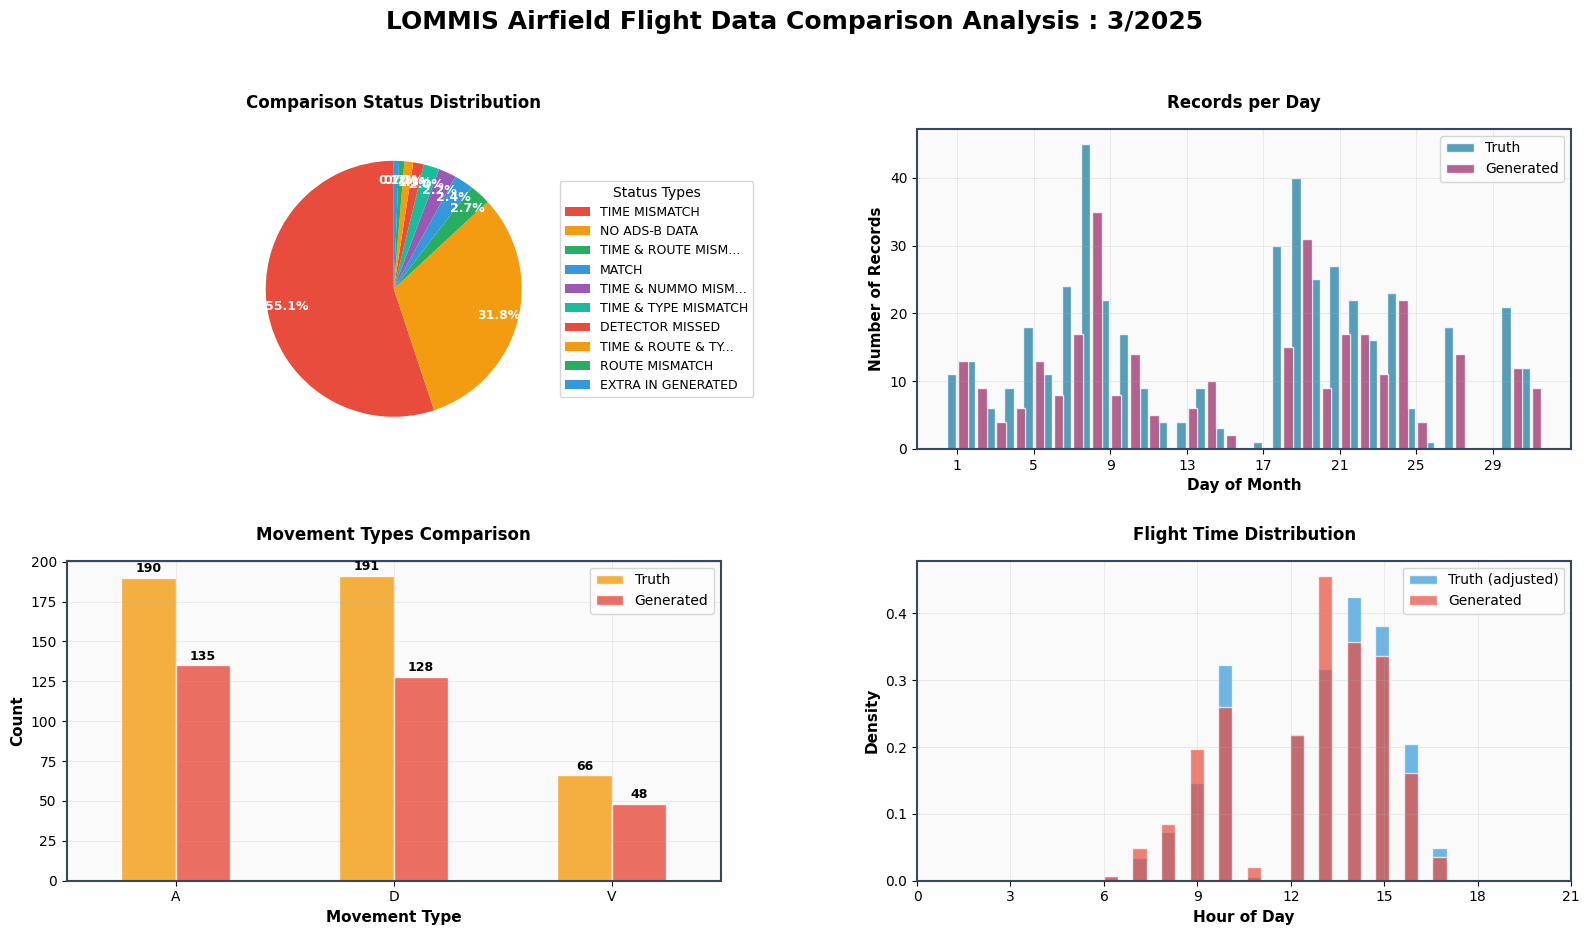


════════════════════════════════════════════════════════════════════════════════
                    FINAL SUMMARY - LOMMIS Flight Data Analysis
════════════════════════════════════════════════════════════════════════════════
┌─────────────────────────────────┬──────────────────────────────────┐
│ Metric                          │ Value                            │
├─────────────────────────────────┼──────────────────────────────────┤
│ Truth Records                   │                              447 │
│ Generated Records               │                              311 │
│ Perfect Matches                 │                               11 │
│ Total Discrepancies             │                              439 │
│ Missing Records                 │                  149 (33.3%)     │
├─────────────────────────────────┼──────────────────────────────────┤
│ Results File                    │ Excel/comparison_results_032025.csv │
└─────────────────────────────────┴─────────────────────────

In [54]:
# Create enhanced visualizations with professional styling
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.patch.set_facecolor('white')

# Enhanced title with mathematical-style formatting
title_text = f'LOMMIS Airfield Flight Data Comparison Analysis : {MONTH}/{YEAR}'
fig.suptitle(title_text, fontsize=18, fontweight='bold', y=0.96)

# 1. Enhanced Status distribution with better text positioning
status_counts = results_df['STATUS'].value_counts()
colors = ['#E74C3C', '#F39C12', '#27AE60', '#3498DB', '#9B59B6', '#1ABC9C']

# Create pie chart with improved text positioning
wedges, texts, autotexts = axes[0,0].pie(status_counts.values, 
                                        labels=None,  # Remove labels from pie chart
                                        autopct='%1.1f%%', 
                                        startangle=90, 
                                        colors=colors[:len(status_counts)],
                                        pctdistance=0.85,  # Move percentage closer to center
                                        textprops={'fontsize': 9, 'fontweight': 'bold'})

# Add title for pie chart
axes[0,0].set_title('Comparison Status Distribution', fontsize=12, fontweight='bold', pad=15)

# Create legend with shortened labels to avoid overlap
short_labels = []
for label in status_counts.index:
    if len(label) > 20:
        short_labels.append(label[:17] + '...')
    else:
        short_labels.append(label)

axes[0,0].legend(wedges, short_labels, title="Status Types", 
                loc="center left", bbox_to_anchor=(1, 0, 0.5, 1), fontsize=9)

# Style percentage text
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(9)

# 2. Records by day with enhanced styling
day_truth = df_truth['DAY'].value_counts().sort_index()
day_generated = df_generated['DAY'].value_counts().sort_index()

x = range(1, 32)
truth_counts = [day_truth.get(day, 0) for day in x]
gen_counts = [day_generated.get(day, 0) for day in x]

bars1 = axes[0,1].bar([d-0.3 for d in x], truth_counts, width=0.5, label='Truth', 
                     alpha=0.8, color='#2E86AB', edgecolor='white', linewidth=1)
bars2 = axes[0,1].bar([d+0.3 for d in x], gen_counts, width=0.5, label='Generated', 
                     alpha=0.8, color='#A23B72', edgecolor='white', linewidth=1)

axes[0,1].set_xlabel('Day of Month', fontsize=11, fontweight='bold')
axes[0,1].set_ylabel('Number of Records', fontsize=11, fontweight='bold')
axes[0,1].set_title('Records per Day', fontsize=12, fontweight='bold', pad=15)
axes[0,1].legend(fontsize=10, loc='upper right')
axes[0,1].grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
axes[0,1].set_xticks(range(1, 32, 4))  # Reduce tick density
axes[0,1].set_facecolor('#FAFAFA')

# 3. Movement types comparison with better spacing
truth_types = df_truth['TYPMO'].value_counts()
gen_types = df_generated['ARR_DEP'].value_counts()

type_comparison = pd.DataFrame({
    'Truth': truth_types,
    'Generated': gen_types
}).fillna(0)

bars = type_comparison.plot(kind='bar', ax=axes[1,0], color=['#F39C12', '#E74C3C'], 
                           alpha=0.8, edgecolor='white', linewidth=1)
axes[1,0].set_title('Movement Types Comparison', fontsize=12, fontweight='bold', pad=15)
axes[1,0].set_ylabel('Count', fontsize=11, fontweight='bold')
axes[1,0].set_xlabel('Movement Type', fontsize=11, fontweight='bold')
axes[1,0].tick_params(axis='x', rotation=0, labelsize=10)
axes[1,0].grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
axes[1,0].legend(fontsize=10, loc='upper right')
axes[1,0].set_facecolor('#FAFAFA')

# Add value labels on bars with better positioning
for container in axes[1,0].containers:
    axes[1,0].bar_label(container, fontsize=9, fontweight='bold', padding=2)

# 4. Time distribution with improved layout
def extract_hour(time_str):
    try:
        return int(str(time_str)[:2]) if pd.notna(time_str) else None
    except:
        return None

truth_hours = df_truth['TIME_ADJUSTED'].apply(extract_hour).dropna()
gen_hours = df_generated['TIME'].apply(extract_hour).dropna()

axes[1,1].hist(truth_hours, bins=24, alpha=0.7, label='Truth (adjusted)', 
               density=True, color='#3498DB', edgecolor='white', linewidth=1)
axes[1,1].hist(gen_hours, bins=24, alpha=0.7, label='Generated', 
               density=True, color='#E74C3C', edgecolor='white', linewidth=1)

axes[1,1].set_xlabel('Hour of Day', fontsize=11, fontweight='bold')
axes[1,1].set_ylabel('Density', fontsize=11, fontweight='bold')
axes[1,1].set_title('Flight Time Distribution', fontsize=12, fontweight='bold', pad=15)
axes[1,1].legend(fontsize=10, loc='upper right')
axes[1,1].grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
axes[1,1].set_xticks(range(0, 24, 3))  # Reduce tick density
axes[1,1].set_facecolor('#FAFAFA')

# Add border to all subplots
for ax in axes.flat:
    for spine in ax.spines.values():
        spine.set_edgecolor('#34495E')
        spine.set_linewidth(1.5)

# Improved layout with better spacing
plt.tight_layout(rect=[0, 0.03, 1, 0.93])  # Leave more space for title and legend
plt.subplots_adjust(hspace=0.35, wspace=0.3)  # Increase spacing between plots
plt.show()

# Define discrepancies variable for summary table
discrepancies = results_df[results_df['STATUS'] != 'MATCH']

# Enhanced summary with table-like formatting
print("\n" + "═"*80)
print("                    FINAL SUMMARY - LOMMIS Flight Data Analysis")
print("═"*80)
print("┌─────────────────────────────────┬──────────────────────────────────┐")
print("│ Metric                          │ Value                            │")
print("├─────────────────────────────────┼──────────────────────────────────┤")
print(f"│ Truth Records                   │ {len(df_truth):>32} │")
print(f"│ Generated Records               │ {len(df_generated):>32} │")
print(f"│ Perfect Matches                 │ {len(results_df[results_df['STATUS'] == 'MATCH']):>32} │")
print(f"│ Total Discrepancies             │ {len(discrepancies):>32} │")
print(f"│ Missing Records                 │ {len(missing_records):>20} ({missing_percentage:.1f}%)     │")
print("├─────────────────────────────────┼──────────────────────────────────┤")
print(f"│ Results File                    │ {results_csv_file.ljust(33)} │")
print("└─────────────────────────────────┴──────────────────────────────────┘")
print("═"*80)